In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
from scipy.signal import convolve2d
from math import *
from tqdm import tqdm
import time import sleep
import scipy.signal as signal
import sys
plt.rcParams['figure.figsize'] = [7, 7]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32") / 255.
    return img

def gray2rgb(image):
    return np.repeat(np.expand_dims(image, 2), 3, axis=2)

def show_image(img):
    if len(img.shape) == 2:
        img = gray2rgb(img)
    plt.imshow(img, interpolation='nearest')

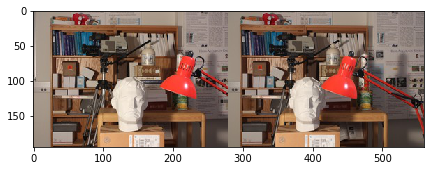

In [22]:
left = load_image('im0.jpg')
right = load_image('im1.jpg')

height,width,_ = left.shape

pad_size = 100

left_pad = np.pad(left, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='constant')
right_pad = np.pad(right, ((pad_size, pad_size), (pad_size, pad_size), (0,0)), mode='constant')

show_image(np.concatenate([left, right], axis=1))

In [86]:
# Some variables that might help you. But you don't have to use them.
max_dx = 50 # max number of displacements to search. make this smaller to speed up
dxs = np.linspace(-max_dx, max_dx, num=2*max_dx+1).astype("int32")

win_size = 5 # size of window you use for ssd computation
lamb_coeff = 0 # coefficient in front of pairwise cost

def l1_score(a,b):
    # TODO: implement a score for L1 distance
    #res = sum(abs(a-b))
    res = abs(a-b)
    return res
def compute_disparity_dp():
    # TODO: calculate the disparity using dynamic programming between left and right
    disparity = np.zeros((height,width))
    
    height_pad, width_pad, d = left_pad.shape
    
    # for each row, compute the shortest path 
    #create a table that store all the cost for each column and disparity
    graph = np.zeros([max_dx*2+1,width])
    # store the previous point
    prev = np.zeros([max_dx*2+1,width], dtype= int)
    h = 100 + pad_size
    for w in range(pad_size,width_pad-pad_size):
        for i in dxs: 
            temp_l = np.zeros([win_size*2+1,win_size*2+1,3])
            temp_r = np.zeros([win_size*2+1,win_size*2+1,3])
            temp_l[:,:,0:3] = left_pad[h-win_size:h+win_size+1, w-win_size:w+win_size+1,0:3]
            temp_r[:,:,0:3] = right_pad[h-win_size:h+win_size+1,i+w-win_size:i+w+win_size+1,0:3]
            ssd = np.sum((temp_l[:,:,0:3]-temp_r[:,:,0:3])**2)
            graph[i+max_dx,w-pad_size] = ssd
    
    # compute the shortest path of markov chain
    g_height, g_width = graph.shape
    
    for c in range(1,g_width):
        # the current disparities
        for i in range(g_height):
            min_cost = sys.maxsize
            min_cost_indice = 0
            # the previous disparities
            for j in range(g_height):
                temp = graph[j,c-1] + lamb_coeff*l1_score(i,j) + graph[i,c]
                if temp < min_cost:
                    # the previous disparity of the disparity i of c column is prev[i,c]
                    min_cost = temp
                    min_cost_indice = j
                
            prev[i,c] = min_cost_indice
            graph[i,c] = min_cost
                    
                
    # the sequence of short path
    # backward process
    
    path_list = []
    # return the indice of the smallest accumulated cost
    indice = np.argmin(graph[:,width-1])
    path_list.insert(0, indice)    
    count = width -1
    while count > 0:
        prev_indice = prev[indice,count]
        path_list.insert(0, prev_indice) 
        indice = prev_indice
        count = count - 1
    path_list = np.asarray(path_list)
    path_list = path_list - max_dx
    disparity[h-pad_size,:] = path_list
    
    print(path_list)
    
    #return disparity
    
    #return graph[:,:]

In [87]:
res = compute_disparity_dp()

[  0   0   0   0   0   5   4   3   2   1   0  -1  -2  -3  -4  -5  -6  -7
  -8  -9  -9  -9  -9  -9  -8  -9  -8  -8  -8  -9  -8  -8  -8  -8  -8  -8
  -8  -8  -8  -8  -7  -7  -7  -7  -7  -7   0  -8  -8  -8  -8  -8  -8  -8
  -8  -8  -8  -8  -8  -8  -8  -8  -8  -8  -8  -8  -8  -8  -8  -9  -9  -9
  -9  -9  -8  -8  -8  -8  -8  -8  -8  -8  -8  -8  -9  -9  -9 -12 -12 -12
 -10 -11 -11 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -12 -15 -15 -16 -19
 -20 -21 -22 -24 -24 -25 -25 -25 -25 -25 -25 -25 -25 -25 -25 -25 -25 -25
 -25 -25 -26 -25 -26 -26 -26 -26 -26 -26 -26 -27 -27 -27 -27 -27 -27 -27
 -27 -27 -38 -39 -38 -39 -39 -35 -17 -18 -19 -20 -21 -22 -23 -24 -25 -26
 -27 -28 -29 -30 -31 -32 -33 -34  50  49  48  47  50  50  50  47  49  50
  49  42  21  21  20  19  17  16  11 -47 -47 -47 -47 -45 -46 -47 -47 -48
 -49 -49 -49 -49 -48 -45 -46 -47 -48 -49 -50 -50 -50 -50 -50 -50 -50 -50
 -50 -50 -50 -50 -50 -50 -50 -50 -50 -50 -50 -50  -7  -7  -7  -7  -7  -7
  -7  -7  -7   8  10  10   9   9   9   9 -30 -30 -4

In [83]:
res[100,:]

array([  0.,   0.,   0.,   0.,   0.,   5.,   4.,   3.,   2.,   1.,   0.,
        -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9.,  -9.,  -9.,
        -9.,  -9.,  -8.,  -9.,  -8.,  -8.,  -8.,  -9.,  -8.,  -8.,  -8.,
        -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -7.,  -7.,  -7.,  -7.,
        -7.,  -7.,   0.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,
        -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,
        -8.,  -8.,  -8.,  -9.,  -9.,  -9.,  -9.,  -9.,  -8.,  -8.,  -8.,
        -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -8.,  -9.,  -9.,  -9., -12.,
       -12., -12., -10., -11., -11., -12., -12., -12., -12., -12., -12.,
       -12., -12., -12., -12., -12., -15., -15., -16., -19., -20., -21.,
       -22., -24., -24., -25., -25., -25., -25., -25., -25., -25., -25.,
       -25., -25., -25., -25., -25., -25., -25., -26., -25., -26., -26.,
       -26., -26., -26., -26., -26., -27., -27., -27., -27., -27., -27.,
       -27., -27., -27., -28., -28., -30., -30., -1

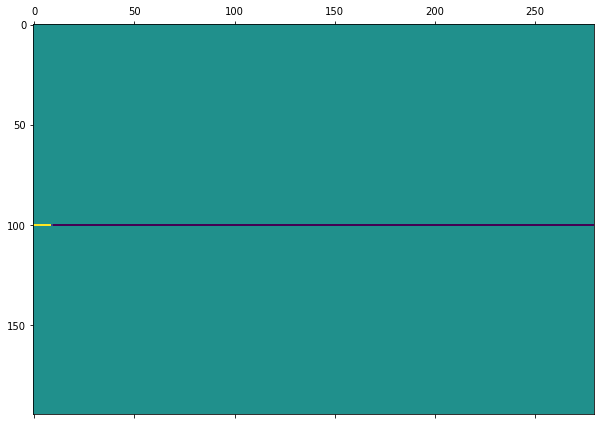

In [35]:
plt.matshow(res)

In [ ]:
# progress bar processing

In [107]:
pbar = tqdm(total=100)
for i in range(10):
    time.sleep(0.1)
    pbar.update(10)
pbar.close()








  0%|          | 0/100 [00:00<?, ?it/s]

In [110]:
#greedy testing
# Some variables that might help you. But you don't have to use them.
# default value win_size = 5
# default max_dx = 30

max_dx = 50 # max number of displacements to search. make this smaller to speed up
dxs = np.linspace(-max_dx, max_dx, num=2*max_dx+1).astype("int32")
win_size = 2 # size of window you use for ssd computation

def compute_disparity():
    # TODO: calculate the disparity using a greedy approach between left and right
    disparity = np.zeros((height,width))
    
    height_pad, width_pad, d = left_pad.shape
    # progress bar

    #pbar = tqdm(range(height))
    pbar = tqdm(total=100)
    step = (1 / height) * 100
    for h in range(pad_size,height_pad-pad_size):
        pbar.update(step)
        for w in range(pad_size,width_pad-pad_size):
            min_ssd = sys.maxsize
            for i in dxs: 
                #compute current disparity
                
                temp_l = np.zeros([win_size*2+1,win_size*2+1,3])
                temp_r = np.zeros([win_size*2+1,win_size*2+1,3])
                # the current point in temp_l: h,w
                # the current point in tem_r: h, i+w
                temp_l[:,:,0:3] = left_pad[h-win_size:h+win_size+1, w-win_size:w+win_size+1,0:3]
                temp_r[:,:,0:3] = right_pad[h-win_size:h+win_size+1,i+w-win_size:i+w+win_size+1,0:3]
                
                ssd = np.sum((temp_l[:,:,0:3]-temp_r[:,:,0:3])**2)
                # set the final disparity to the disparity that makes the ssd min
                if ssd < min_ssd:
                    min_ssd = ssd
                    disparity[h-pad_size,w-pad_size] = i  
    pbar.close()
    return disparity

disparity = compute_disparity()
plt.matshow(disparity)









  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: write() missing 1 required positional argument: 's'